In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch

from torchvision import datasets, transforms
from skimage.filters import threshold_otsu, threshold_local
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter


from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time
from PIL import Image
from sklearn.cluster import KMeans

# 1 Clustering Images

Cette section présente plusieurs méthodes de clustering et montre comment les utiliser pour grouper des images afin de trouver des groupes d'images similaires. 
Le clustering peut être utilisé pour la reconnaissance d'images, pour diviser des ensembles de données d'images, et pour l'organisation et la navigation. 
Nous verrons également comment utiliser le clustering pour visualiser la similarité entre les images.

### K-Means Clustering

K-means est un algorithme de clustering très simple qui tente de partitionner les données d'entrée en k-clusters. 
K-means fonctionne en raffinant de manière itérative une estimation initiale des centroïdes de classe comme
comme suit :
1. Initialiser les centroïdes $μ_i, i = 1, ..., k$, au hasard ou avec une certaine approximation.
2. Assignez chaque point de données à la classe $c_i$ de son centroïde le plus proche.
3. Mettre à jour les centroïdes comme la moyenne de tous les points de données assignés à cette classe.
4. Répétez les étapes 2 et 3 jusqu'à la convergence.

K-means essaie de minimiser la variance totale au sein de la classe.

L'algorithme ci-dessus est un algorithme de raffinement heuristique qui fonctionne bien dans la plupart des cas, mais il ne garantit pas que la meilleure solution soit trouvée.
Pour éviter les effets du choix d'une mauvaise initialisation des centroïdes, l'algorithme est souvent exécuté plusieurs fois avec différents centroïdes d'initialisation. 
Ensuite, la solution présentant la plus faible variance V est sélectionnée.
Le principal inconvénient de cet algorithme est que le nombre de clusters doit être décidé au préalable, et un choix inapproprié donnera de mauvais résultats de clustering. 
Les avantages sont qu'il est simple à mettre en œuvre, qu'il est parallélisable et qu'il fonctionne bien pour un large éventail de problèmes sans qu'il soit nécessaire de le régler.

### 1.1 Clustering avec Sklearn

Bien que simple à mettre en œuvre, il n'est pas nécessaire de le faire. La bibliothèque Sklearn est fournie avec une implémentation des k-means. Voici comment l'utiliser.

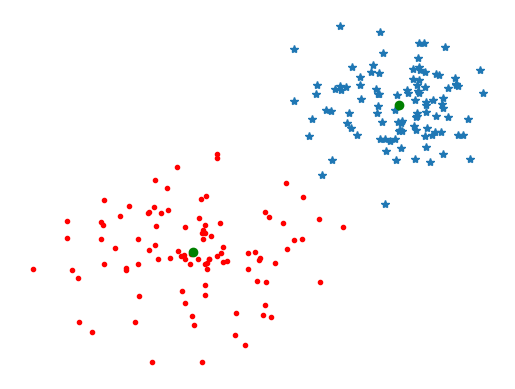

In [10]:
#Commençons par créer un échantillon de données 2D pour illustrer notre propos :
class1 = 1.5 * np.random.randn(100,2)
class2 = np.random.randn(100,2) + np.array([5,5])
X = np.vstack((class1,class2))

kmeans = KMeans(n_init = 'auto', n_clusters=2, random_state=0).fit(X)

# Cela génère deux classes normalement distribuées en deux dimensions. 
# Pour essayer de regrouper les points, exécutez k-means avec k = 2 comme ceci :
centroids = kmeans.cluster_centers_

# The variance is returned but we don’t really need it, since the SciPy implementation computes several runs (default is 20) and selects the one with smallest variance for us.
# Now you can check where each data point is assigned using the vector quantization function in the SciPy package:
code = kmeans.predict(X)

# En vérifiant la valeur du code, nous pouvons voir s'il y a des affectations incorrectes. 
# Pour visualiser, nous pouvons tracer les points et les centroïdes finaux :
plt.figure()
ndx = np.where(code==0)[0]
plt.plot(X[ndx,0],X[ndx,1],'*')

ndx = np.where(code==1)[0]
plt.plot(X[ndx,0],X[ndx,1],'r.')
plt.plot(centroids[:,0],centroids[:,1],'go')
plt.axis('off')
plt.show()

#### 📝 Q1 : Sur l'exemple ci-dessous que pouvez-vous conclure sur l'efficacité de clustering des k-means sur ce dataset synthétique ?

_Note : Here the function "where()" gives the indices for each class._

### 1.2 Clustering Images

---
__Storyboard:__

Dans cet exercice on se place dans le cadre dans un site qui s'apparenterait à Vinted, les utilisateurs mettent en ligne des photos de leur vêtements sans pour autant dire de quel type il s'agit: chaussures/sac/pull/etc.

Une partie des utilisateur ont fait correctement correspondre un __label__ (y_train) à chacun de leurs article (X_train), cependant une autre partie des utilisateurs n'a pas fait cet effort.

On cherche dans un premier temps à regrouper les articles présent dans cette base d'images afin de leur assigner une __classe__ par la suite.

---

Comme évoqué précédemment: le clustering est un algorithme d'apprentissage automatique non supervisé qui reconnaît les modèles sans étiquettes spécifiques et regroupe les données en fonction des caractéristiques. Dans notre cas, nous allons voir si un algorithme de clustering (k-means) peut trouver un modèle entre différentes images des vêtements présents dans f-MNIST sans les étiquettes (__y__).

Ici seront utilisés K-Means et PCA.
L'analyse en composantes principales (Principal Component Analysis) ou PCA est une méthode permettant de réduire les dimensions d'un ensemble de données donné tout en conservant la majeure partie de sa variance. Wikipedia la définit comme suit : "La PCA est définie comme une transformation linéaire orthogonale qui transforme les données dans un nouveau système de coordonnées de sorte que la plus grande variance par une certaine projection scalaire des données se situe sur la première coordonnée (appelée première composante principale), la deuxième plus grande variance sur la deuxième coordonnée, et ainsi de suite."

_Note: Maitriser ce sujet est tout sauf essentiel ici, il faut simplement comprendre que la PCA est utilisée dans un but de réduction de dimension._

En résumé, la PCA réduit les dimensions de l'ensemble de données tout en conservant la plupart des informations. Par exemple, si un ensemble de données possède 1000 caractéristiques, il peut-être réduit à 200 caractéristiques en fonction de la quantité spécifiée de variance conservée. 
Plus la variance retenue est élevée, plus l'information est conservée, mais plus les dimensions résultantes seront importantes.

Moins de dimensions signifie moins de temps pour former et tester un modèle. 
Dans certains cas, les modèles qui utilisent un ensemble de données avec la PCA sont plus performants que sur l'ensemble de données original. 

__Le plan d'attaque est le suivant:__ exécuter les k-means sur le jeu de données, mais seulement après avoir appliqué la PCA sur celui-ci, donc:

1. Charger le dataset depuis keras
2. Pré-traiter les données, aplatir les données (de 60000 x ? x ? array à 60000 x ? array)
3. Appliquez la PCA pour réduire les dimensions (? à 420 avec une variance de 0,98).
4. Appliquez la classification K-means sur l'ensemble de données PC (10 clusters).
5. Observez et analysez les résultats à l'aide de matplotlib.


__Chargement du Dataset__ f-MNIST est un jeu de données se composant d'__images de mêmes tailles__, de différentes variétés de vêtements, les chiffres représentant les types de vêtements suivants.

![alt text](data/samples_images/f-MNIST.png "f-MNIST examples")

In [11]:
# Mapping from label indices to description
label_to_desc = ['T-Shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandals', 'Shirt', 'Sneaker', 'Bag', 'Ankle boots']

# Loading the dataset
# Assuming you want to use the Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Convert the PyTorch datasets to NumPy arrays
X_train, y_train = train_dataset.data.numpy(), train_dataset.targets.numpy()
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()


#### 📝 Q2: Après avoir chargé le dataset, déterminer de quelles tailles sont les images contenues initialement dans le dataset.

#### 📝 Q3: Afficher quelques images contenues dans ce dataset.

In [16]:
X_train.shape

(60000, 28, 28)

In [17]:
#Q2
img_size = 28

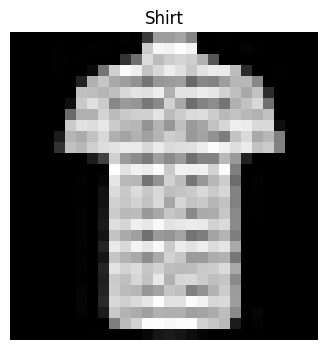

In [18]:
#Q3
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
idx = np.random.randint(0,  X_train.shape[0], 1)[0] #random index value

ax.imshow(X_train[idx], cmap='gray') #Plot image
ax.set_title(label_to_desc[y_train[idx]]) #Display label 
ax.axis('off')
plt.show()


__Prétraitement des données__: nous transformons les données en tableau 2D à partir d'un tableau 3D en aplatissant les caractéristiques en une dimension. 
Chaque image du tableau img_size x img_size est maintenant un tableau unique de img_size² caractéristiques. Ainsi, notre jeu de données devient un tableau de dimension 60000 x img_size² à partir de sa version initiale de dimension 60000 x img_size x img_size.

In [19]:
#Transformation de X en un tableau 2D pour PCA et ensuite k-means
X_train_flat = X_train.reshape(-1, img_size*img_size ) #Nous n'utiliserons que X pour le clustering. Pas besoin de y.

print ("The shape of X_train_flat is " + str(X_train_flat.shape))
print ("The shape of y_train is " + str(y_train.shape)) #Nous n'utiliserons y que pour vérifier notre clustering.

The shape of X_train_flat is (60000, 784)
The shape of y_train is (60000,)


__PCA (Principle Component Analysis)__: nous allons maintenant utiliser la PCA sur notre dataset pour réduire ses dimensions. 
Nous choisirons notre variance retenue de __0,98__ (valeur sélectionnée par "trial and error") et l'utiliserons sur notre ensemble de données.

#### 📝 Q4 : Editez le code suivant pour afficher la dimension des datasets avant et après PCA. Il est possible d'obtenir la dimension du dataset avant d'employer la fonction "transform", indice: il suffit d'utiliser un des attributs de l'objet "pca".

In [21]:
# Création d'une instance du modèle
variance = 0.98 #Plus la variance expliquée est élevée, plus le modèle restera précis, mais plus de dimensions seront présentes.
pca = PCA(variance)
t0 = time()

pca.fit(X_train_flat) #Ajustement de notre instance de PCA en fonction de nos données

print("Number of components after PCA = {}".format(pca.n_components_)) 

print("'pca.fit': done in %0.3fs" % (time() - t0))
print("Number of components before PCA  = {}".format(X_train_flat.shape[1]))

X_train_pca = pca.transform(X_train_flat)
print("Dimension of our data after PCA = {}".format(X_train_pca.shape[1]))

Number of components after PCA = 349
'pca.fit': done in 13.490s
Number of components before PCA  = 784
Dimension of our data after PCA = 349


Nous pouvons également effectuer une transformation inverse des données pour voir comment les données ont été altérées par la PCA.

#### 📝 Q5 : Compléter le code ci-dessous pour affichez correctement les images. _Indice: vous devrez utiliser la fonction 'reshape'

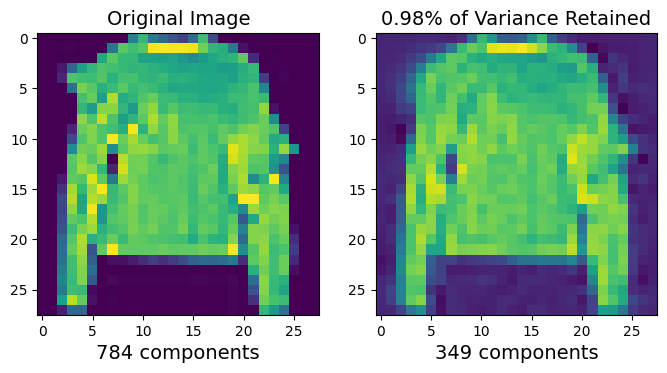

In [23]:
reconstruction_train = pca.inverse_transform(X_train_pca)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
n = np.random.randint(0, 60000, 1)[0] #random index value

# Original Image

axs[0].set_xlabel('{} components'.format(X_train.shape[1]*X_train.shape[2]), fontsize = 14)
axs[0].set_title('Original Image', fontsize = 14)
axs[0].imshow(X_train[n])
# Reconstruction after PCA

axs[1].set_xlabel('{} components'.format(X_train_pca.shape[1]), fontsize = 14)
axs[1].set_title('{}% of Variance Retained'.format(variance), fontsize = 14)
axs[1].imshow(reconstruction_train[n].reshape((img_size, img_size)))
plt.show() 
#Normalement les deux images doivent se ressembler même si on a deux fois moins 
#d'informations sur celle de droite

__K-Means Clustering__: Pour construire le modèle k-means, nous avons besoin des valeurs des paramètres suivants.


- __'init'__ : Méthode d'initialisation des centroïdes. __La valeur sera : "k-means++"_. k-means++ : Sélectionne les centres initiaux des clusters pour le clustering k-mean d'une manière intelligente pour accélérer la convergence.

- __'n_clusters'__ : Le nombre de clusters à former ainsi que le nombre de centroïdes à générer. __La valeur sera : 10__ ( nous avons 10 classes selon l'INDEX, ce n'est peut-être pas le meilleur mais c'est suffisant pour notre contexte)

- __'n_init'__ : Nombre de fois que l'algorithme k-means sera exécuté avec différentes graines de centroïdes. Le résultat final sera la meilleure sortie de n_init exécutions consécutives en termes d'inertie. __La valeur sera : 35__ sur la base de nos résultats d'inertie (ce n'est peut-être pas le meilleur mais c'est suffisant pour notre contexte).

Nous avons maintenant notre modèle et nous l'adaptons à notre jeu de données. 
Essayez d'abord d'utiliser les paramètres mentionnés pour vérifier les résultats. 
Vous pourrez les changer plus tard et observer des résultats différents.

#### 📝 Q6 : En exploitant les questions précédentes et les exemples initiliser un objet 'k_means' avec les paramètres souhaités et ajuster le (avec la fonction '.fit') à vos données (obtenues après PCA).

In [24]:
kmeans = KMeans(init = 'k-means++', n_clusters = 10, n_init=35).fit(X_train_pca)

Maintenant, le modèle a été ajusté sur notre jeu de données d'images sur lequel nous avons effectué une ACP. 
Les données sont maintenant divisées en 10 clusters. 
Nous devons maintenant vérifier quel type d'image se retrouve dans chacun de ces clusters et voir s'il y a un certain schéma.
Rappelez-vous que la distribution sera similaire mais que le nombre (étiquette) des clusters pourrait être différent lorsque vous exécuterez cette opération.

__Visualisation et analyse__: Après le fit, nous utilisons le code suivant pour visualiser nos clusters.

#### 📝 Q7 : En utilisant l'attribut '.labels_' de l'objet 'k_means' vous pourrez obtenir les labels affectés aux objets du dataset 'X_train_pca'. Completer le code suivant :

Le nombre de labels distincts prédits par les kmeans est de 10


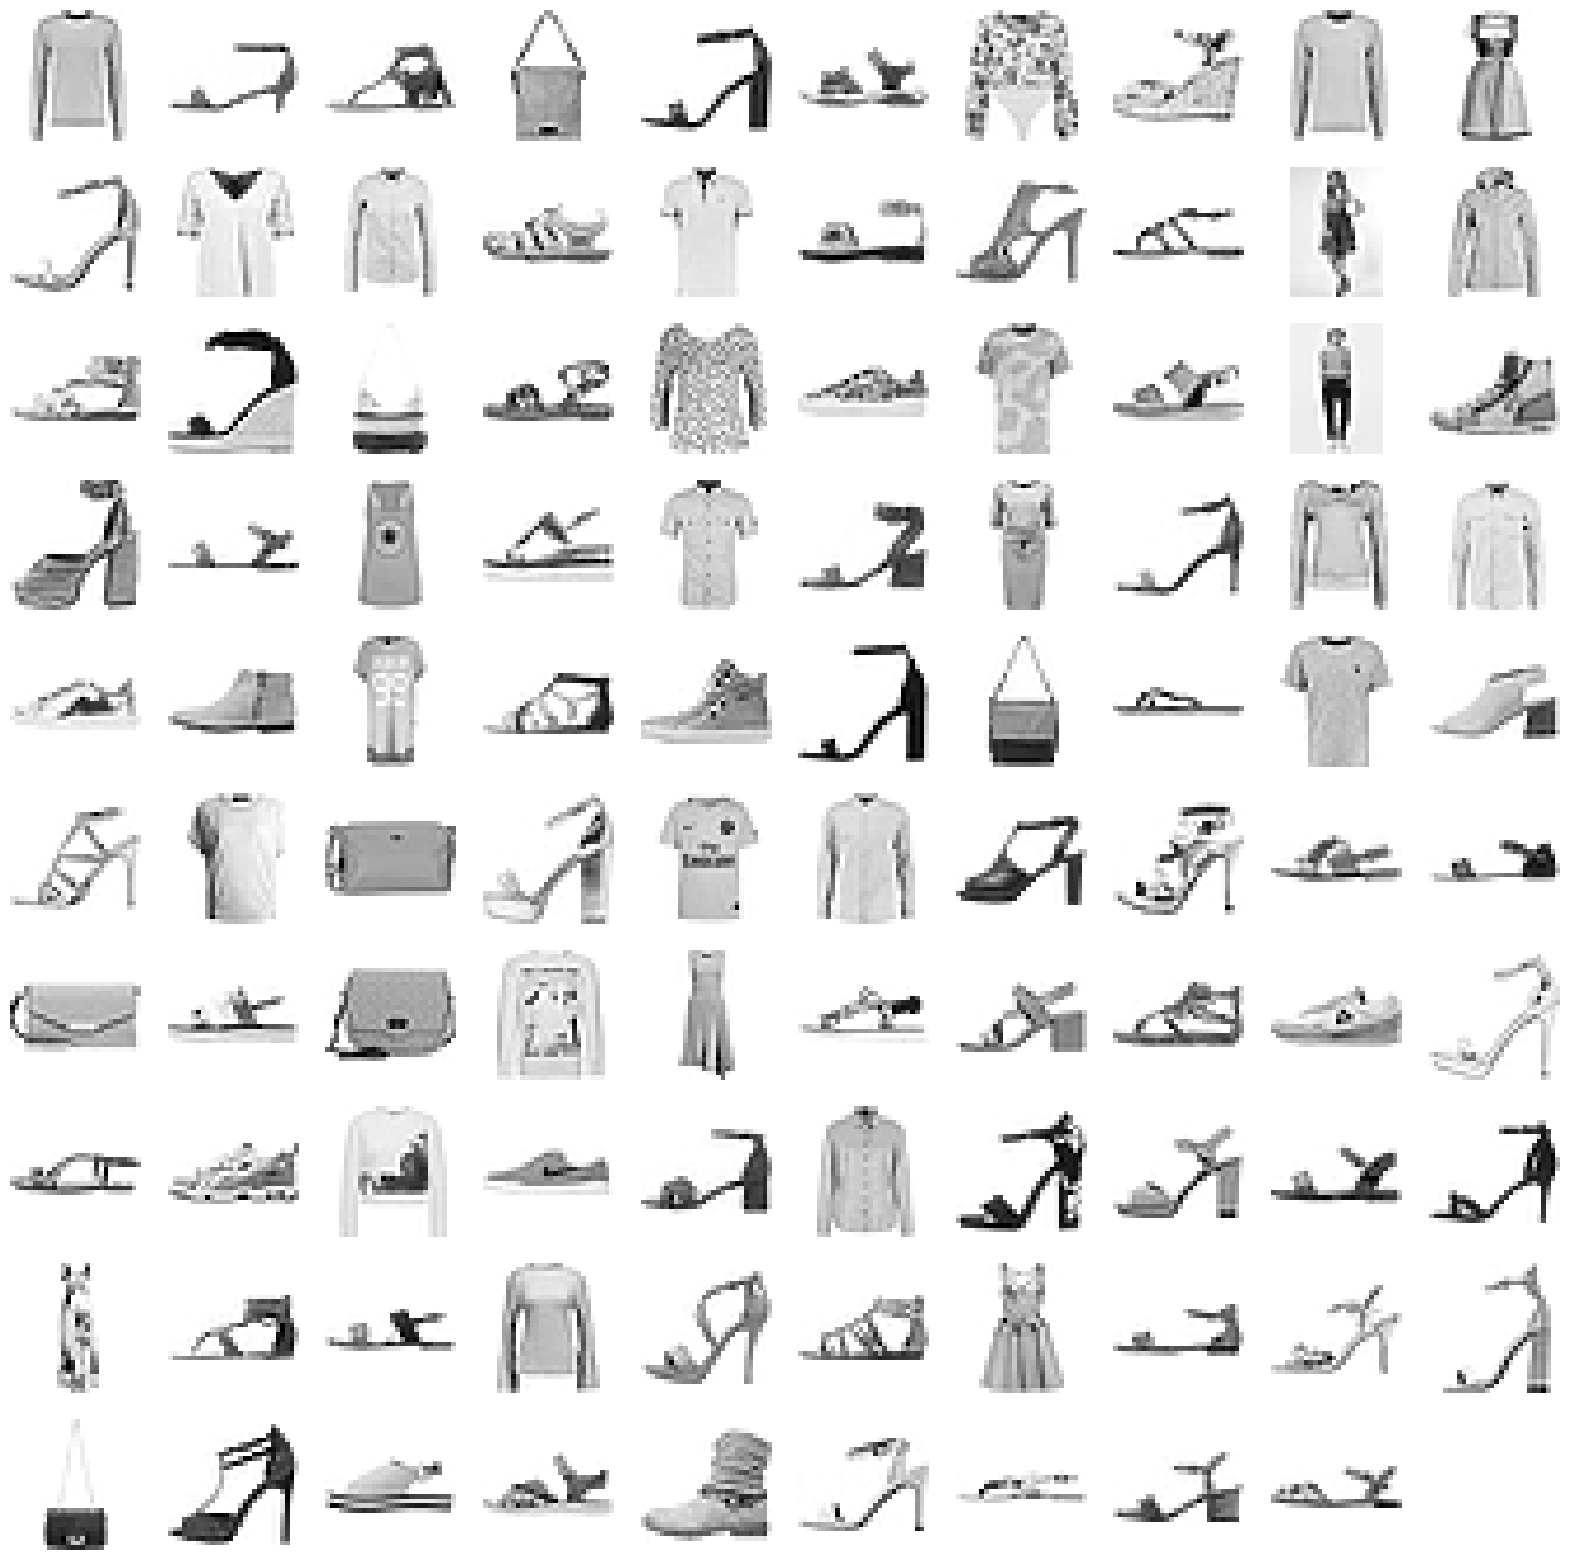

In [25]:
k_means_labels_training = kmeans.labels_

G = len(np.unique(k_means_labels_training)) #Number of labels

print('Le nombre de labels distincts prédits par les kmeans est de {}'.format(G))

#matrice 2D pour un tableau d'indices de l'étiquette donnée
cluster_index= [[] for i in range(G)]
for i, label in enumerate(k_means_labels_training, 0):
    for n in range(G):
        if label == n:
            cluster_index[n].append(i)
        else:
            continue

plt.figure(figsize=(20,20))

clust = 3 #entrer le numéro du label à visualiser (compris entre 0 et G)
num = 100 #nombre de données à visualiser à partir du cluster
for i in range(1, num): 
    plt.subplot(10, 10, i); #(Nombre de lignes, Nombre de colonnes par ligne, numéro d'article)
    plt.imshow(X_train[cluster_index[clust][i+500]].reshape(X_train.shape[1], X_train.shape[2]), cmap = plt.cm.binary)
    plt.axis('off')
plt.show()

Si tout s'est bien passé vous devriez obtenir une mosaique d'images plutôt similaires, pour 'clust=3' j'obtiens un groupe composé uniquement de bottes.

On fait l'hypothèse que notre modèle est "fiable" et qu'on peut ainsi s'en servir pour suggérer à un utilisateur uploadant une image sans label un label associé.
Pour cela on va choisir aléatoirement une image dans le dataset de test "X_test" et tenter de lui associé dans un premier temps 5 articles où images similaire présentes dans "X_train" et la classe la plus probable associée.

#### 📝 Q8 : compléter le code ci-dessous pour réaliser la suggestions d'articles associée et la prédiction de la classe de l'image choisie.

Bonjour, vous avez omis de sélectionner une catégorie pour votre article.
Si il correspond aux suggestions ci-dessous, est-ce que "Ankle boots" serait une catégorie adéquat ?


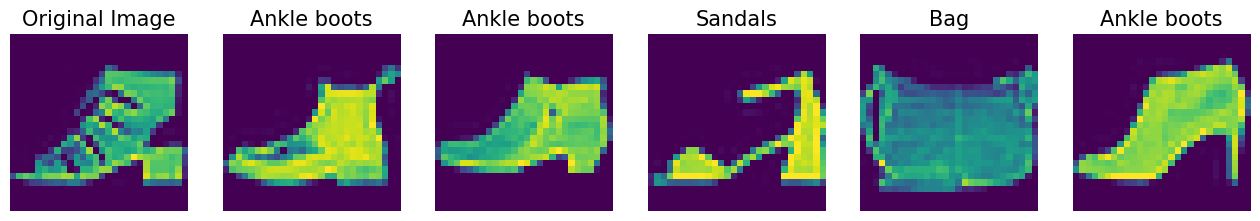

Label réel: Sandals


In [27]:
idx = np.random.randint(0, X_test.shape[0])
x_test = X_test[idx]
x_test_flat = x_test.reshape(-1, img_size*img_size )
x_test_pca = pca.transform(x_test_flat)
y_test_pred = kmeans.predict(x_test_pca)

#Sélection de 5 images "similaires" à partir des labels k_means_labels obtenus après le fit
idxs = np.where(k_means_labels_training == y_test_pred)[0]
idxs = np.random.choice(idxs, 5)

_X, _y = X_train[idxs], y_train[idxs]

_most_frequent_label = np.argmax(np.bincount(_y))

print('Bonjour, vous avez omis de sélectionner une catégorie pour votre article.') 
print('Si il correspond aux suggestions ci-dessous, est-ce que \"{}\" serait une catégorie adéquat ?'.format(label_to_desc[_most_frequent_label]))

fig, axs = plt.subplots(1, 6, figsize = (16, 8))
axs[0].imshow(x_test)
axs[0].axis('off')
axs[0].set_xlabel('', fontsize = 14)
axs[0].set_title('Original Image', fontsize = 15)

for i in range(5):
    axs[i+1].imshow(_X[i])
    axs[i+1].axis('off')
    axs[i+1].set_title('{}'.format(label_to_desc[_y[i]]), fontsize = 15)
plt.show()

#Impression du label réel
print('Label réel: {}'.format(label_to_desc[y_test[idx]]))

### 1.3 Clustering Pixels

Avant de clore cette section, nous allons examiner un exemple de regroupement de pixels individuels plutôt que d'images entières. 
Le regroupement des régions et des pixels d'une image en composants "significatifs" est appelé segmentation d'image. 
L'application naïve des k-means sur les valeurs des pixels ne donnera rien de significatif, sauf pour les images très simples.
Des modèles de classe plus sophistiqués que la couleur moyenne des pixels ou la cohérence spatiale sont nécessaires pour produire des résultats utiles. 
Pour l'instant, appliquons simplement les k-means aux valeurs RGB et préoccupons-nous de la résolution des problèmes de segmentation.
L'exemple de code suivant prend une image, la réduit à une version de plus faible résolution dont les pixels sont les valeurs moyennes des régions de l'image d'origine (prises sur une grille carrée de taille pas-à-pas), et regroupe les régions à l'aide de k-means :

#### 📝 Q9 : Completez le code ci-dessous pour que les kmeans découpent l'image en 2 groupes distincts.

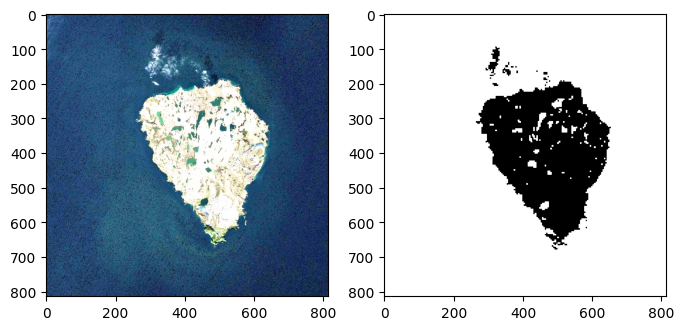

In [28]:
steps = 200 # image is divided in steps*steps region
im = Image.open('data/misc/island.jpg')
hw = im.size
c = (hw[0]//2, hw[1]//2)
im = np.array(im.crop((c[0]-hw[1]//2, c[1]-hw[1]//2, c[0]+hw[1]//2, c[1]+hw[1]//2)))
dx = im.shape[0] // steps
dy = im.shape[1] // steps

# compute color features for each region
features = []
for x in range(steps):
    for y in range(steps):
        R = np.mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,0])
        G = np.mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,1])
        B = np.mean(im[x*dx:(x+1)*dx,y*dy:(y+1)*dy,2])
        features.append([R,G,B])

features = np.array(features,'f') # make into array
kmeans = KMeans(n_init='auto', n_clusters=2).fit(features) #Easy

preds = kmeans.predict(features)
preds = preds.reshape((steps, steps))

im_k = np.array(Image.fromarray(preds).resize((im.shape[1], im.shape[0])))

fig, axs = plt.subplots(1, 2, figsize = (8, 8))
axs[0].imshow(im)
axs[1].imshow(im_k, cmap='Greys')

plt.show()

#### 📝 Q10 : Sur l'image segmentée, quelle est la proportion occupée par la surface qui représente l'ile sur l'image ?

In [30]:
S_r = np.sum(im_k == 1)/im_k.size #Nombre de pixels égaux à 1 divisé par nombre de pixels
print('Surface relative = {:.2f}%.'.format(S_r*100))

Surface relative = 16.15%.


#### 📝 Q11 : La photo a été réalisée avec l'échelle suivante 1km = 30pixels, tenter d'obtenir une approximation de la surface émergé des terres.

PS: les nuages feront partis de la marge d'erreurs.

_Note : L'île est située au large de la Norvège et s'appelle "Bjørnøya" si vous souhaitez obtenir la surface "officielle" de l'île, attention la segmentation ne comptera pas les lacs intérieurs comme faisant partie de la surface de l'île vous devriez logiquement obtenir une surface plus faible que celle fournie par Wikipédia._

In [31]:
S_island = S_r*30**2
print('Surface des terres = {:.2f}km².'.format(S_island))

Surface des terres = 145.39km².


_L'île est située au large de la Norvège et s'appelle "Bjørnøya" si vous souhaitez obtenir la surface "officielle" de l'île, attention la segmentation ne comptera pas les lacs intérieurs comme faisant partie de la surface de l'île vous devriez logiquement obtenir une surface plus faible que celle fournie par Wikipédia._

The input to k-means is an array with steps*steps rows, each containing the R, G, and B mean values.
To visualize the result, we use SciPy’s imresize() function to show the steps*steps image at the original image coordinates. 
The parameter interp specifies what type of interpolation to use; here we use nearest neighbor so we don’t introduce new pixel values at the transitions between classes.
Figure 6-4 shows results using 50 × 50 and 100 × 100 regions for two relatively simple example images. 
Note that the ordering of the k-means labels (in this case the colors in the result images) is arbitrary.
As you can see, the result is noisy despite down-sampling to only use a few regions. 
There is no spatial consistency and it is hard to separate regions, like the boy and the grass in the lower example. 
Spatial consistency and better separation will be dealt with later, together with other image segmentation algorithms.
Now let’s move on to the next basic clustering algorithm.

### 1.4 Dénombrement d'objets similaires

"Gros coup de filet pour les policiers Niortait ce samedi, dans le quartier de la gare, pas très loin du commissariat. 
Ils ont contrôlé un jeune homme d'une vingtaine d'années au comportement suspect, ce dernier manipulait des substances devant son garage afin de les vendre au prochain teknival".

Voilà le contenu (fictif) d'un article paru dans la presse locale, la saisi se présente sous différents pocheton dont le nombre de pillule varie, la composition de celles-ci étant artisanale les policiers ne peuvent exploiter une approche par le poids pour déterminer le nombre de pillules trouvées chez le jeune homme.

On se propose ici de réaliser un algorithme capable de compter le nombre de pillule sur chaque photographie.

On va utiliser ici la transformée de Hough, dans sa forme la plus simple, est une méthode de détection des lignes droites, mais elle peut également être utilisée pour détecter des cercles ou des ellipses. 

Mais dans un premier temps on va devoir segmenter les pillules du fond.

#### 📝 Q12 : compléter le code ci-dessous pour obtenir une image segmentée.

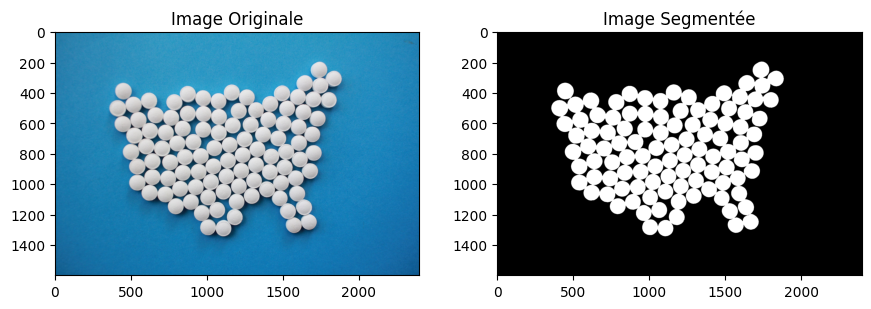

In [34]:
# Load picture and detect edges
img_rgb = img_as_ubyte(Image.open('data/misc/pills.jpg'))
w, h, d = img_rgb.shape
assert d == 3
image_array = np.reshape(img_rgb, (w * h, d))

kmeans = KMeans(n_init='auto', n_clusters=2).fit(image_array) #Easy

img_segmented = kmeans.predict(image_array)
img_segmented = img_segmented.reshape((w, h))


fig, axs = plt.subplots(1, 2, figsize=(9, 3))

axs[0].imshow(img_rgb, cmap=plt.cm.gray)
axs[0].set_title('Image Originale')
axs[1].imshow(img_segmented, cmap=plt.cm.gray)
axs[1].set_title('Image Segmentée')

fig.tight_layout()
plt.show()

L'algorithme "watershed" est un algorithme classique utilisé pour la segmentation, c'est-à-dire pour séparer différents objets dans une image.

À partir de marqueurs définis par l'utilisateur, l'algorithme de la "ligne de partage des eaux" traite les valeurs des pixels comme une topographie locale (élévation). 
L'algorithme "inonde" les bassins à partir des marqueurs jusqu'à ce que les bassins attribués à des marqueurs différents se rencontrent sur les lignes de partage des eaux. Dans de nombreux cas, les marqueurs sont choisis comme des minima locaux de l'image, à partir desquels les bassins sont inondés.

Dans l'exemple ci-dessous, deux cercles qui se chevauchent doivent être séparés. Pour ce faire, on calcule une image qui est la distance au fond. Les maxima de cette distance (c'est-à-dire les minima de l'opposé de la distance) sont choisis comme marqueurs et l'inondation des bassins à partir de ces marqueurs sépare les deux cercles le long d'une ligne de partage des eaux.

Voir Wikipedia pour plus de détails sur l'algorithme.

Nous exploiterons uniquement une partie de cette algorithme :)

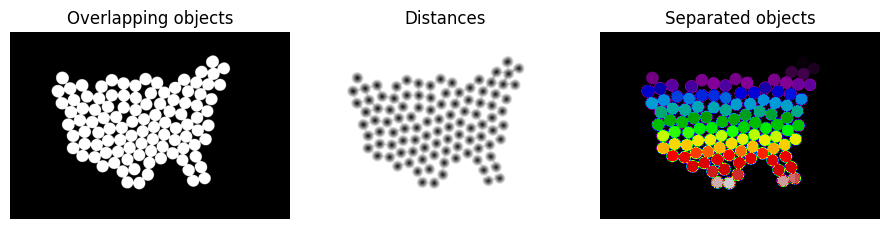

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image = 255*img_segmented

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

On remarque que la "distance" permet d'identifier les objets de l'image et de les séparer en cas de léger overlap.

_Note: distance_transform_edt calcule la distance entre les points non nuls (c'est-à-dire ceux qui ne sont pas en arrière-plan) et le point nul (c'est-à-dire l'arrière-plan) le plus proche._


#### 📝 Q13: Complétez le code suivante pour obtenir le nombre de pillules. _Note: vous pourrez utiliser la methode "unique" de numpy_

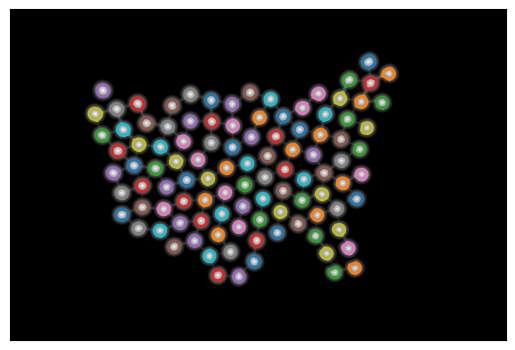

L'image contient 105 objets


In [39]:
from skimage.measure import find_contours


# Find contours at a constant value of 25
contours = find_contours(distance, level = 25)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(distance, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

print('L\'image contient {} objets'.format(len(contours)))

__Refs:__
    
- [1] A. Ng, Machine Learning by Stanford University. (n.d.). Retrieved from https://www.coursera.org/learn/machine-learning
- [2] S Joel Franklin , K-Means Clustering for Image Classification(2020)
- [3] Michael Galarnyk, PCA + Logistic Regression (MNIST)(2018)